# Notebook for Fruit Image classification
classification of fruit using fastai library (docs.fast.ai), which runs on top of pytorch

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

TODO provare a aggiungere altre metriche

In [331]:
from fastai.vision import *
from fastai.metrics import error_rate
from fastai.callbacks import CSVLogger
from pathlib import Path
import numpy as np
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [3]:
path_img = Path("/root/fruit-detection/dataset_classification")
batch_size = 64
np.random.seed(20) #random seed for reproduce results

create dataset object using a folder source folder formatted as `label1/* label2/* ..`. Do not use cross validation, split it 80% 20 % for training validation. Apply all fastai builtin transformations and normalize (still need to understand well what it does)

#### Dataset creation
Information available at the following link https://docs.fast.ai/vision.data.html#ImageDataBunch

In [10]:
data = ImageDataBunch.from_folder(path_img,ds_tfms=get_transforms(), size=224, bs=batch_size).normalize(imagenet_stats)

In [11]:
data.classes

['Albicocca',
 'Banana',
 'Carota',
 'Cetriolo',
 'Champignon',
 'Ciliegia',
 'Cipolla',
 'Kiwi',
 'Lime',
 'Mela',
 'Patata',
 'Peperoncino',
 'Pera',
 'Pesca',
 'Prugna rossa',
 'Zucchino',
 'pomodoro_ciliegino',
 'pomodoro_sanmarzano']

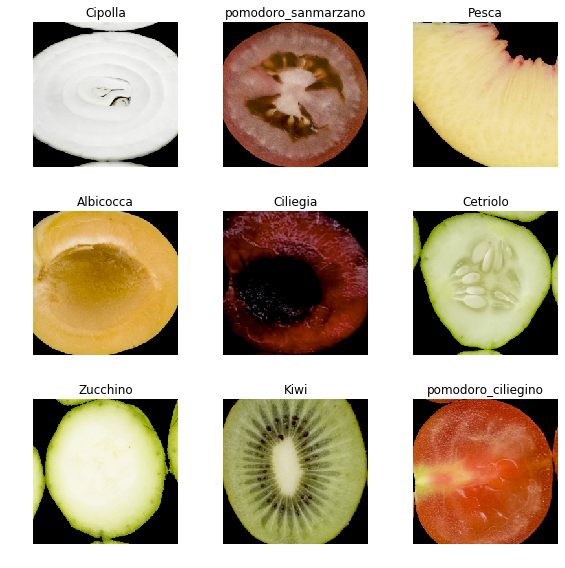

In [12]:
#show some images from dataset
data.show_batch(rows=3, figsize=(8,8))

#### CNN Model
Create a model using renet34 pretrained on imagenet

In [13]:
learn = create_cnn(data, models.resnet34, metrics=[error_rate], callback_fns=[CSVLogger])

Learning rate selection

In [8]:
learn.lr_find(end_lr=100)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


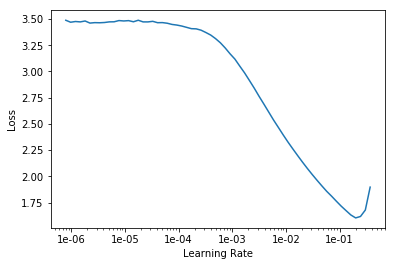

In [9]:
learn.recorder.plot()

Regarding under/overfitting problems, please refer to the following links:
1. https://stats.stackexchange.com/questions/187335/validation-error-less-than-training-error/187404#187404
2. https://link.springer.com/article/10.1007/s13244-018-0639-9

In [14]:
epochs = 3
lr = 1e-3
learn.fit_one_cycle(epochs, lr) #make 4 learning epoch

epoch,train_loss,valid_loss,error_rate,time
1,2.429019,0.615006,0.059211,00:09
2,1.216323,0.076345,0.013158,00:09
3,0.737493,0.062382,0.009868,00:08


after 3 learning epoch we have achieved a 0% error rate

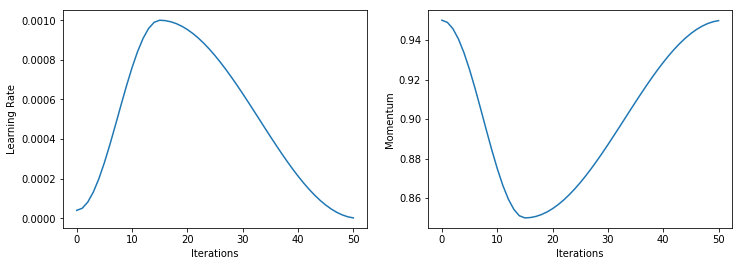

In [11]:
learn.recorder.plot_lr(show_moms=True)

Text(0, 0.5, 'Error rate')

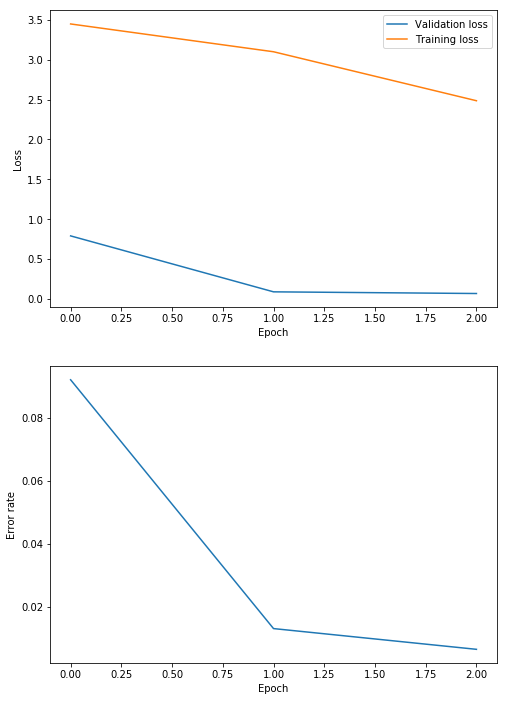

In [12]:
fig,ax = plt.subplots(2,1,figsize=(8,12))
ax[0].plot(list(range(epochs)),learn.recorder.val_losses, label='Validation loss')
ax[0].plot(list(range(epochs)),[learn.recorder.losses[i] for i in range(epochs+2,epochs*(epochs+3),epochs+3)], label='Training loss')
#ax[0].plot(list(range(epochs)),[learn.recorder.losses[i] for i in range(0,len(learn.recorder.losses),epochs-3)], label='Training loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend(loc='upper right')
ax[1].plot(list(range(epochs)),learn.recorder.metrics)
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Error rate')

In [13]:
learn.save('roberto_model-1', return_path=True)

PosixPath('/root/fruit-detection/dataset_classification/models/roberto_model-1.pth')

In [14]:
interp = ClassificationInterpretation.from_learner(learn)

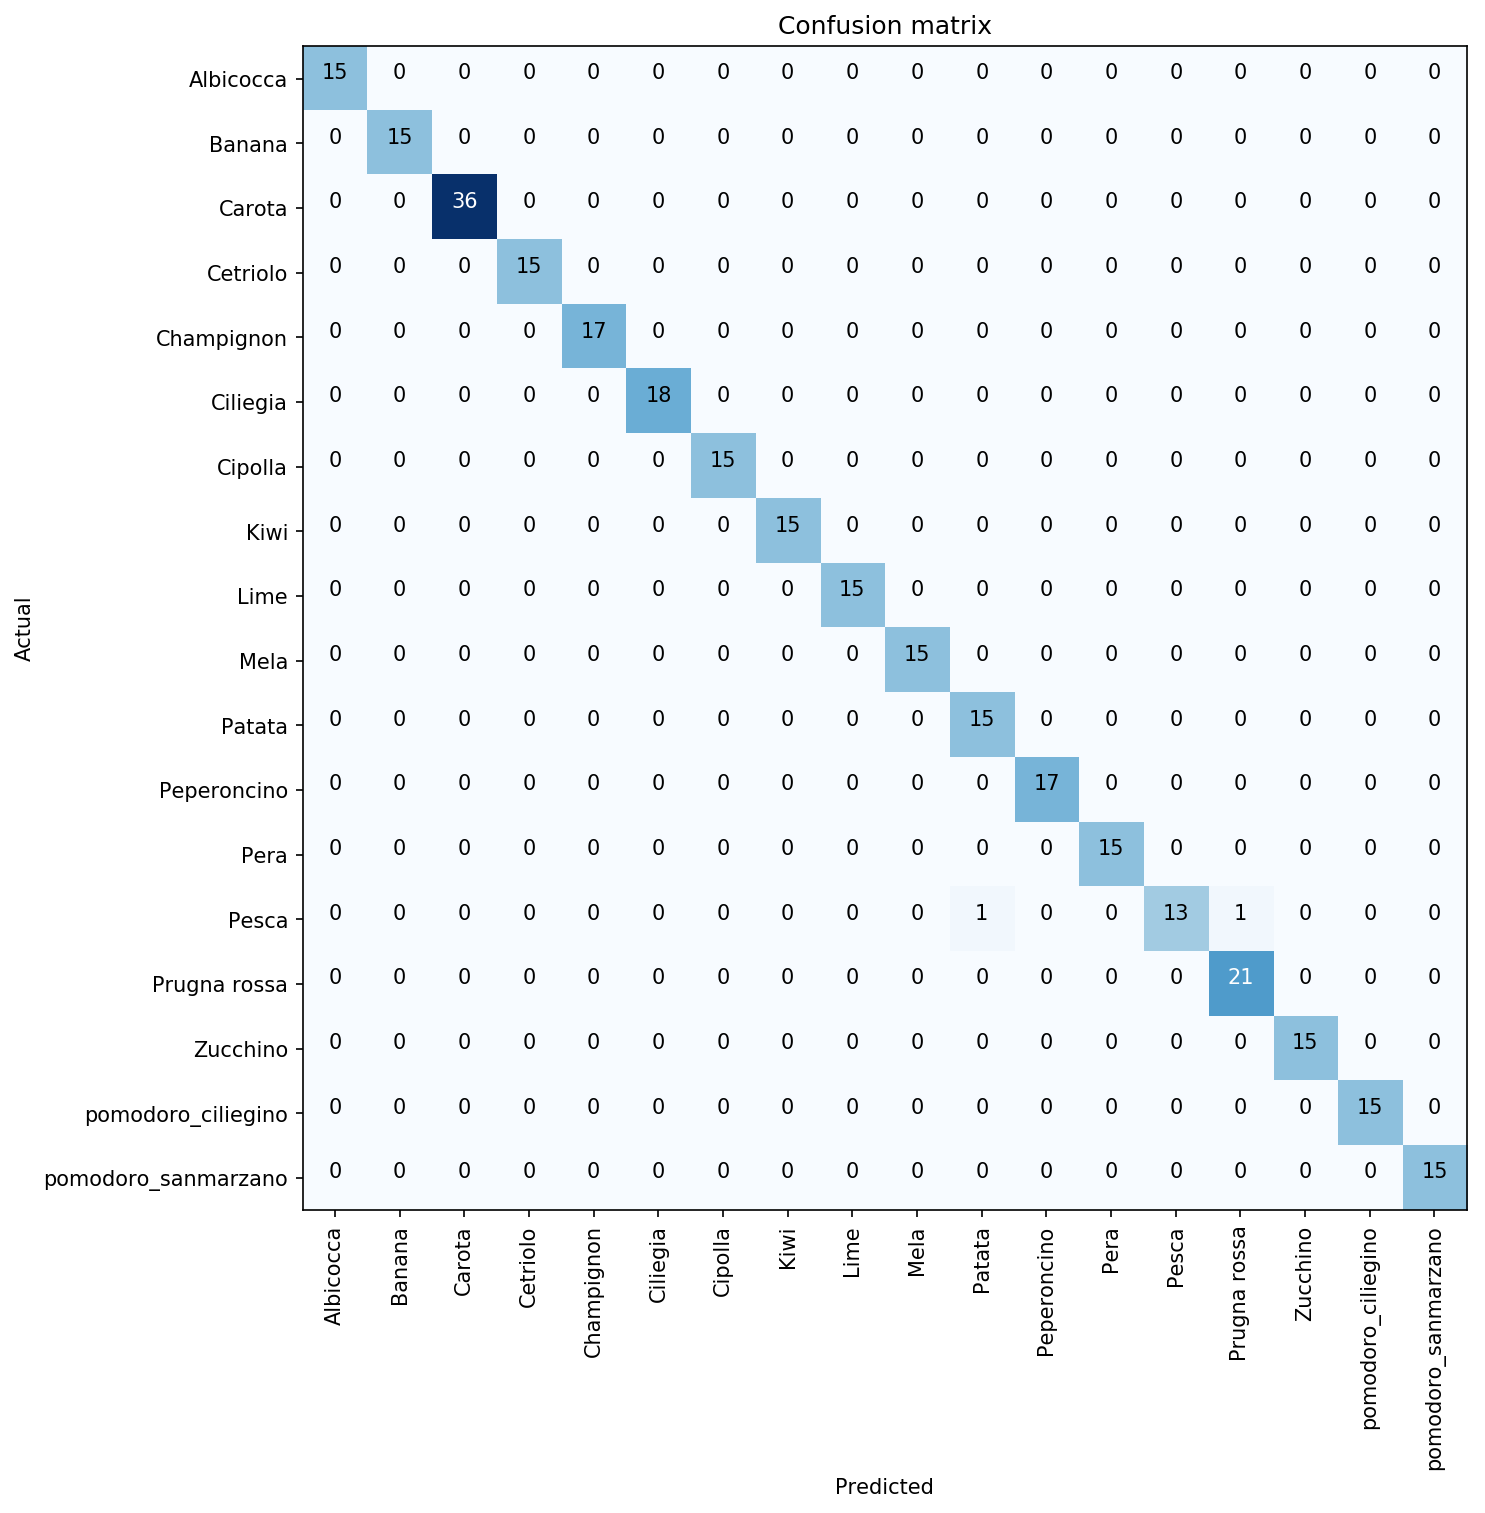

In [37]:
interp.plot_confusion_matrix(figsize=(10,10), dpi=150)

In [16]:
interp.most_confused(min_val=1)

[('Pesca', 'Patata', 1), ('Pesca', 'Prugna rossa', 1)]

#### Commento di Roberto
Dai uno sguardo a questo paragrafo https://docs.fast.ai/vision.learner.html#ClassificationInterpretation
La probability è molto importante per capire la capacità predittiva di un modello.
Per ogni singola immagine è possibile capire con quale probabilità questa è stata associata al label corretto.
Più è alto tale valore, più ovviamente il modello funziona bene.
Se guardi la prima immagine in alto a sx, la prugna rossa ha una probability del 57% di essere prugna rossa (non è proprio così eccelente).
Estrarre le metriche da ogni immagine e mediarle per classe, ci può aiutare a descrivere la bontà del modello per ogni classe di prodotto ed a migliorarlo di conseguenza (facendo per esempio il transfer learning su altre CNN).
Insomma, non ci dobbiamo fermare all'errore totale di predizione (o, viceversa, alla sola accuratezza media del modello, che corrisponde a 1 - error_rate)

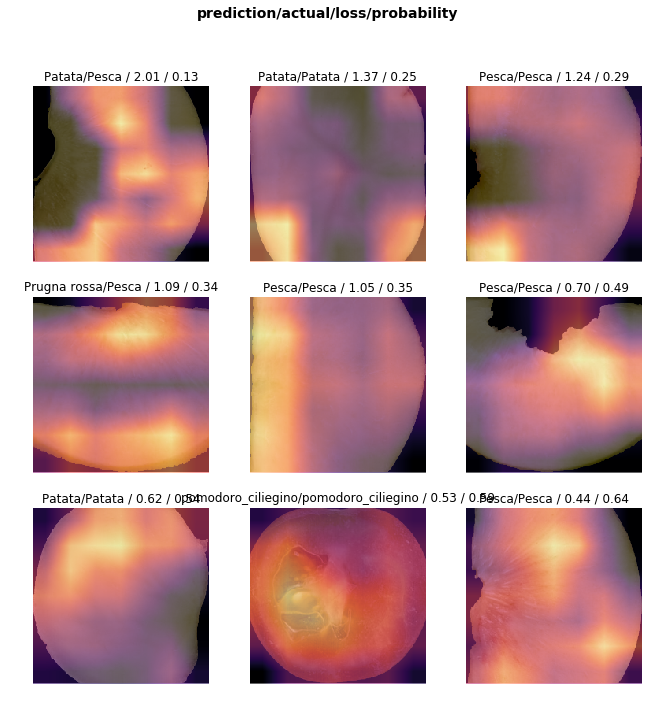

In [17]:
interp.plot_top_losses(9, figsize=(11,11))

In [19]:
test_path = Path("dataset_classification_final_test/")

In [405]:
def test_model_class(folder):   
    results = {'paths':[],
               'actual_idx': [],
               'pred_idx': [],
               'pred_class': [],
               'pred_class': [],
               'probability': [],
               'misclassified': []}
    
    files_list = [files for files in folder.iterdir() if files.suffix == '.png']
    for f in files_list:
        misclass = False
        img = open_image(f)
        pred_class,pred_idx,outputs = learn.predict(img)
        if not (str(pred_class) == folder.name):
#             wrong +=1
            print(f"Error! predicted class: '{pred_class}' vs actual class: '{folder.name}'")
            # print(img) @Simone I think that printing path makes more sense
            print("\t",f)
            misclass = True
        results['paths'].append(f)
        results['pred_idx'].append(int(pred_idx))
        results['pred_class'].append(str(pred_class))
        results['probability'].append(outputs)
        results['misclassified'].append(misclass)
    # actual_idx += 1
    return results   

def test_model_all(root_path):
    defaults.device = torch.device('cpu') #set cpu for inference (@Simone I am not really sure if it is a good idea, I'll investigate)
    tot = 0
    wrong = 0
    actual_idx = 0 #@Simone which is the purpose
    results = {}
    folders_list = sorted([folders for folders in test_path.iterdir()])
    for folder in folder_list:        
        result = test_model_class(folder)
        tot += len(result['misclassified'])
        wrong += result['misclassified'].count(True)
        actual_idx += 1
        results[folder.name] = result
    print(f"error rate: {round(wrong/tot*100,2)}%")
    defaults.device = torch.device('cuda') #set gpu again for training
    return results

In [406]:
results = test_model_all(test_path)

Error! predicted class: 'Carota' vs actual class: 'Pesca'
	 dataset_classification_final_test/Pesca/Pesca_21.png
Error! predicted class: 'Patata' vs actual class: 'Pesca'
	 dataset_classification_final_test/Pesca/Pesca_79.png
Error! predicted class: 'Patata' vs actual class: 'Pesca'
	 dataset_classification_final_test/Pesca/Pesca_71.png
Error! predicted class: 'Carota' vs actual class: 'Pesca'
	 dataset_classification_final_test/Pesca/Pesca_54.png
Error! predicted class: 'pomodoro_sanmarzano' vs actual class: 'pomodoro_ciliegino'
	 dataset_classification_final_test/pomodoro_ciliegino/pomodoro_ciliegino_42.png
error rate: 0.81%


In [409]:
def pred_analysis(class_name, result_class,verbose=True, picture=False):
    """ takes a dict which is a element in the results dict generated by test_model_class
    TODO write what it does"""
    counter = 0
    no_errors = True
    if result_class['misclassified'].count(True) == 0:
        #no classification error
        if verbose: print(f"Actual {class_name} - no classification errors")

    for i in result_class:
        if i == True:
            no_errors = False
            idx = result_class['pred_idx'][counter]
            prob = round(float(result_class['probability'][counter][idx])*100,2)
            print(f"Actual {fclass} recognised as {result_class['pred_class'][counter]} (image n.{str(counter)} - pred_idx: {idx}, P: {str(prob)}%)")
            if picture:
                display(Image(str(result_class['path'][counter]), width=100))
        counter += 1
   
       
                      
def pred_error(fclass, fresults, verbose = False, picture = False):
    if fclass == 'all':
        for k,v in fresults.items():
            pred_analysis(k, v, verbose, picture)
#         for i in range(0, len(fresults)):
#             pred_analysis(list(results.keys())[i], fresults, verbose, picture)         
    else:
        pred_analysis(fclass, fresults[fclass], verbose, picture)

In [410]:
pred_error('all', results, True, True)

Actual Albicocca - no classification errors
Actual Banana - no classification errors
Actual Carota - no classification errors
Actual Cetriolo - no classification errors
Actual Champignon - no classification errors
Actual Ciliegia - no classification errors
Actual Cipolla - no classification errors
Actual Kiwi - no classification errors
Actual Lime - no classification errors
Actual Mela - no classification errors
Actual Patata - no classification errors
Actual Peperoncino - no classification errors
Actual Pera - no classification errors
Actual Pesca recognised as Carota (image n.10 - pred_idx: 2, P: 23.38%)
Not available class Pesca
Actual Prugna rossa - no classification errors
Actual Zucchino - no classification errors
Actual pomodoro_ciliegino recognised as pomodoro_sanmarzano (image n.0 - pred_idx: 17, P: 80.39%)
Not available class pomodoro_ciliegino
Actual pomodoro_sanmarzano - no classification errors


In [ ]:
# the function extracts the average probability values for an actual class
def pred_plot(actual_class, fresults, plot = True):
    try:
        # acquire the list of classes
        classes = list(fresults.keys())
                      
        # acquire the number of samples
        samples = len(results[actual_class]['probability'])
        
        ave_probs = []
                      
        for c in classes:
             # exctract the pred_idx from each class
            idx = fresults[c]['actual_idx'][0]
            temp_probs = []
             
            # extract the probability associated to each class for every sample          
            for s in range(samples):
                temp_probs.append(fresults[actual_class]['probability'][s][idx])
           
            # compute the average probability on class at time
            ave_probs.append(np.mean(temp_probs)) 

        # barplot colors
        bar_colors = ['gray']*(len(classes)+1)
        bar_colors[fresults[actual_class]['actual_idx'][0]] = 'blue'
        miss_array = np.array(results[actual_class]['misclassified'])
        index_array = np.array(results[actual_class]['pred_idx'])
        miss_classes = index_array[miss_array]
        miss_classes = np.unique(miss_classes)
        for i in miss_classes:
            bar_colors[i] = 'red'

        # barplot show
        plt.ylim(0, 1)
        plt.ylabel('Avrage probability')
        plt.xticks(range(len(ave_probs)), classes, rotation = 'vertical')
        plt.bar(range(len(ave_probs)), ave_probs, color = bar_colors)

        blue_patch = mpatches.Patch(color='blue', label='Correctly classified')
        red_patch = mpatches.Patch(color='red', label='Misclassified')
        gray_patch = mpatches.Patch(color='gray', label='Correctly discarded')
        plt.legend(handles=[blue_patch, gray_patch, red_patch])
        
        # averaged probability
        return ave_probs
    
    except KeyError:
        print("Not available class")

In [408]:
pred_error('all', results, True, True)

Actual Albicocca - no classification errors
Actual Banana - no classification errors
Actual Carota - no classification errors
Actual Cetriolo - no classification errors
Actual Champignon - no classification errors
Actual Ciliegia - no classification errors
Actual Cipolla - no classification errors
Actual Kiwi - no classification errors
Actual Lime - no classification errors
Actual Mela - no classification errors
Actual Patata - no classification errors
Actual Peperoncino - no classification errors
Actual Pera - no classification errors
Actual Pesca recognised as Carota (image n.10 - pred_idx: 2, P: 23.38%)
Not available class
Actual Prugna rossa - no classification errors
Actual Zucchino - no classification errors
Actual pomodoro_ciliegino recognised as pomodoro_sanmarzano (image n.0 - pred_idx: 17, P: 80.39%)
Not available class
Actual pomodoro_sanmarzano - no classification errors


The plot here below refers to the content of the tutorial available at the following link:
https://www.tensorflow.org/tutorials/keras/basic_classification

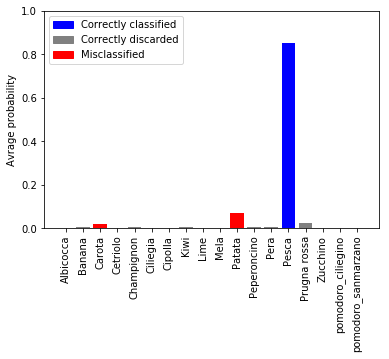

In [388]:
probs = pred_plot('Pesca', results)

In [384]:
probs

[0.0011085721,
 0.9707546,
 0.0016732016,
 0.0005872968,
 0.0028224462,
 0.0005095525,
 0.0014143854,
 0.001406322,
 0.0016897363,
 0.0004399382,
 0.006470935,
 0.0011060864,
 0.0010355486,
 0.0010742865,
 0.0017293016,
 0.005195414,
 0.0006876989,
 0.00029475984]

In [144]:
dir(learn)

['TTA',
 '__annotations__',
 '__class__',
 '__dataclass_fields__',
 '__dataclass_params__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__post_init__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'add_time',
 'backward',
 'bn_wd',
 'callback_fns',
 'callbacks',
 'clip_grad',
 'create_opt',
 'csv_logger',
 'data',
 'destroy',
 'dl',
 'export',
 'fit',
 'fit_one_cycle',
 'freeze',
 'freeze_to',
 'get_preds',
 'init',
 'interpret',
 'layer_groups',
 'load',
 'loss_func',
 'lr_find',
 'lr_range',
 'metrics',
 'mixup',
 'model',
 'model_dir',
 'one_cycle_scheduler',
 'opt',
 'opt_func',
 'path',
 'pred_batch',
 'predict',
 'purge',
 'recorder',
 'save',
 'show_results',
 'split',
 'summary',
 'to_fp16',
 'to_fp32',
 'train_b

In [23]:
learn.data

ImageDataBunch;

Train: LabelList (1138 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Lime,Lime,Lime,Lime,Lime
Path: /root/fruit-detection/dataset_classification;

Valid: LabelList (304 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Lime,Lime,Lime,Lime,Lime
Path: /root/fruit-detection/dataset_classification;

Test: None

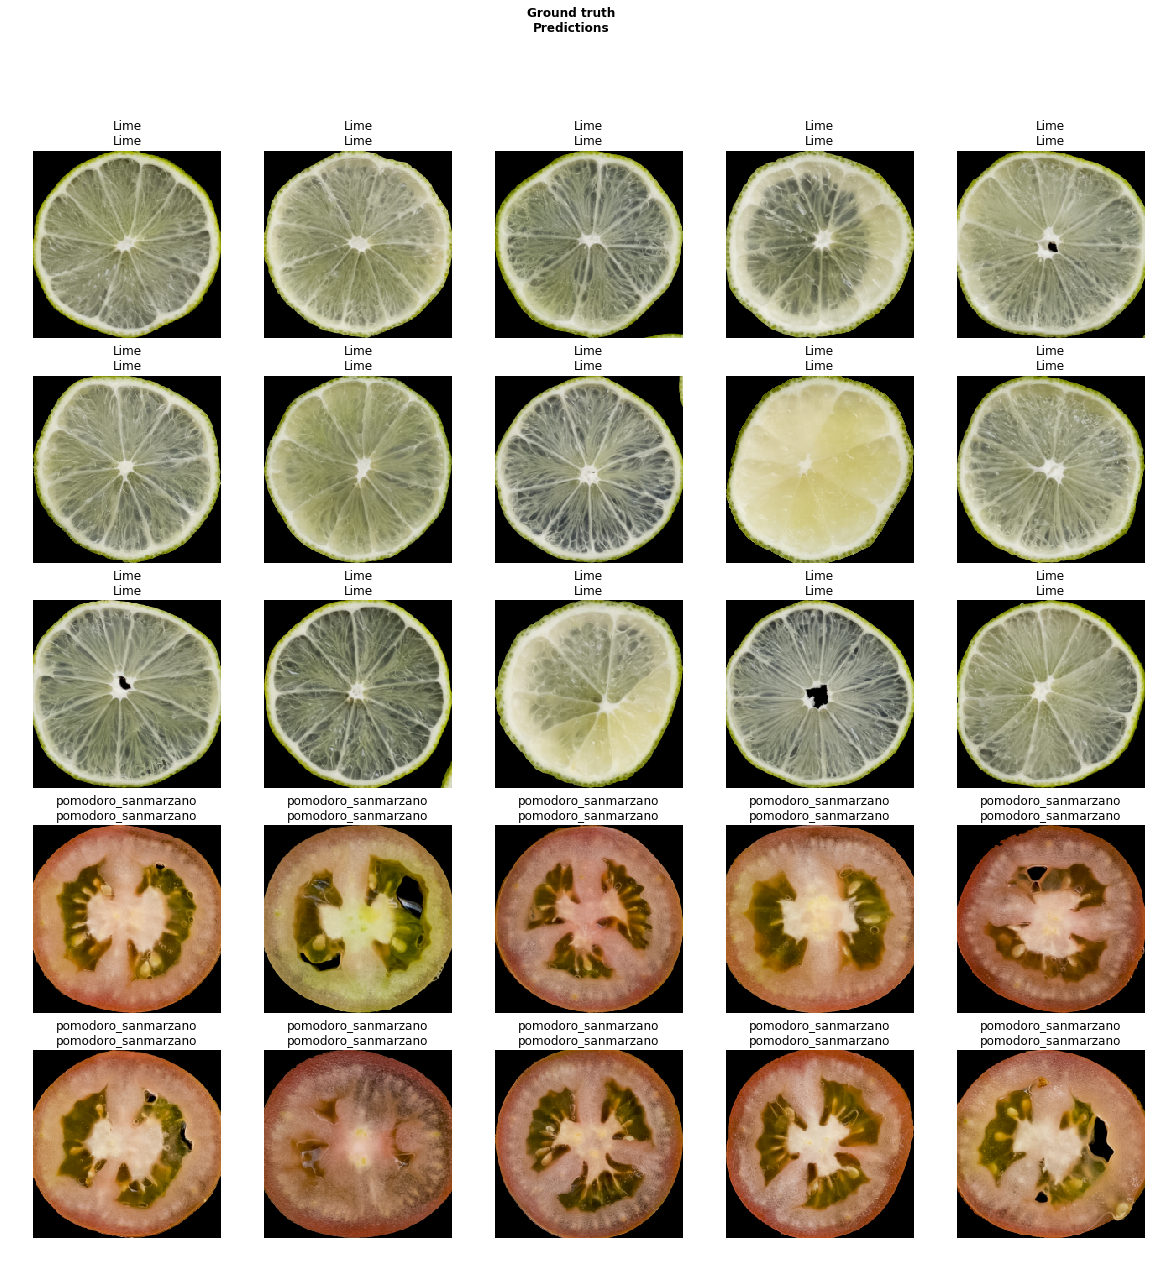

In [24]:
learn.show_results()

In [25]:
learn.validate()

[0.06238247, tensor(0.0099)]